In [1]:
# import the necessary packages
from sklearn.cluster import DBSCAN
from imutils import build_montages
import numpy as np
import pickle
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.cluster as cluster
import seaborn as sns
from tqdm import tqdm

encodings = 'encodings0.pickle'
jobs = -1
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
data = pickle.loads(open(encodings, "rb").read())
for ie in range(1,10):
    data1 = pickle.loads(open('encodings'+str(ie)+'.pickle', "rb").read())
    data = data + data1
data = np.array(data)
encodings = [d["encoding"] for d in data]
print("[INFO] found",len(data), "images")

[INFO] loading encodings...
[INFO] found 18895 images


In [3]:
faces_all = []
# get all faces
for i in tqdm(range(len(data))):
    # load the input image and extract the face ROI
    image = cv2.imread(data[i]["imagePath"])
    scale_percent = 50
    width = int(image.shape[1])
    height = int(image.shape[0])
    resize_ratio = 1920 * scale_percent/100 / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    # resize image
    image = cv2.resize(image, target_size)

    (top, right, bottom, left) = data[i]["loc"]
    face = image[top:bottom, left:right]

    # force resize the face ROI to 96x96 and then add it to the
    # faces montage list
    face = cv2.resize(face, (96, 96))
    faces_all.append(face)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18895/18895 [09:54<00:00, 31.76it/s]


In [7]:
# f = open("faces_all.pkl", "wb")
# f.write(pickle.dumps(faces_all))
# f.close()
faces_all = pickle.loads(open("faces_all.pkl", "rb").read())

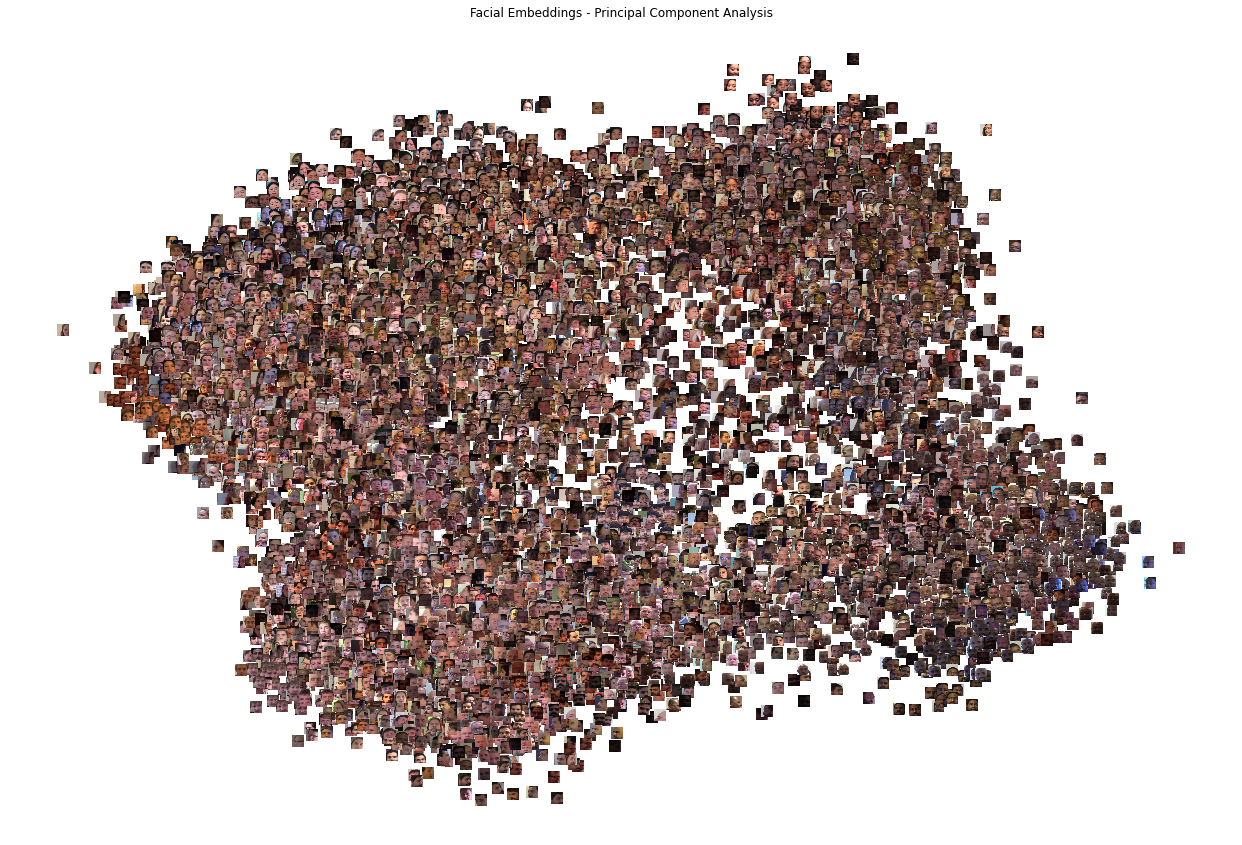

In [6]:
# visualize the faces using PCA
def scatter_thumbnails(data, images, zoom=0.12, colors=None):
    assert len(data) == len(images)

    # reduce embedding dimentions to 2
    x = PCA(n_components=2).fit_transform(data) if len(data[0]) > 2 else data

    # create a scatter plot.
    f = plt.figure(figsize=(22, 15))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], s=4)
    _ = ax.axis('off')
    _ = ax.axis('tight')

    # add thumbnails :)
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    for i in range(len(images)):
        image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        im = OffsetImage(image, zoom=zoom)
        bboxprops = dict(edgecolor=colors[i]) if colors is not None else None
        ab = AnnotationBbox(im, x[i], xycoords='data',
                            frameon=(bboxprops is not None),
                            pad=0.02,
                            bboxprops=bboxprops)
        ax.add_artist(ab)
    return ax

_ = scatter_thumbnails(encodings, faces_all, 0.12)
plt.title('Facial Embeddings - Principal Component Analysis')
plt.show()

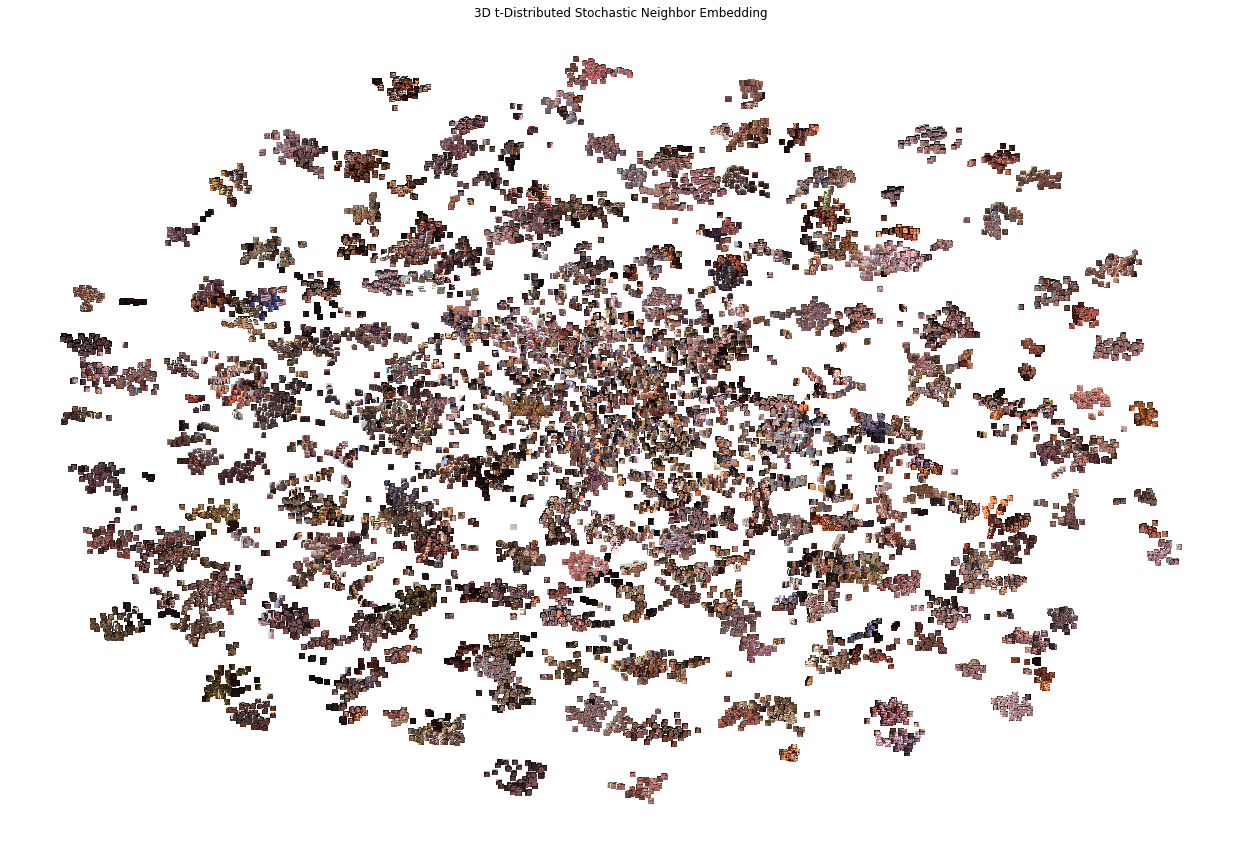

In [7]:
# PCA first to speed it up
x = PCA(n_components=50).fit_transform(encodings)
x = TSNE(perplexity=50,
         n_components=3).fit_transform(x)

_ = scatter_thumbnails(x, faces_all, zoom=0.06)
plt.title('3D t-Distributed Stochastic Neighbor Embedding')
plt.show()

In [9]:
def plot_clusters(data, algorithm, *args, **kwds):
    labels = algorithm(*args, **kwds).fit_predict(data)
    return labels

# clusters = plot_clusters(x, hdbscan.HDBSCAN, alpha=1.0, min_cluster_size=2, min_samples=1)
clusters = plot_clusters(x, cluster.DBSCAN, n_jobs=-1, eps=1, min_samples=5)

labelIDs = np.unique(clusters)
unlabeledFaces = len(np.where(clusters == -1)[0])
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("[INFO] # unlabeled faces: {}".format(unlabeledFaces))
print("[INFO] # unique faces: {}".format(numUniqueFaces))

[INFO] # unlabeled faces: 933
[INFO] # unique faces: 570


Text(0.5, 1.0, 'Clusters found by DBSCAN')

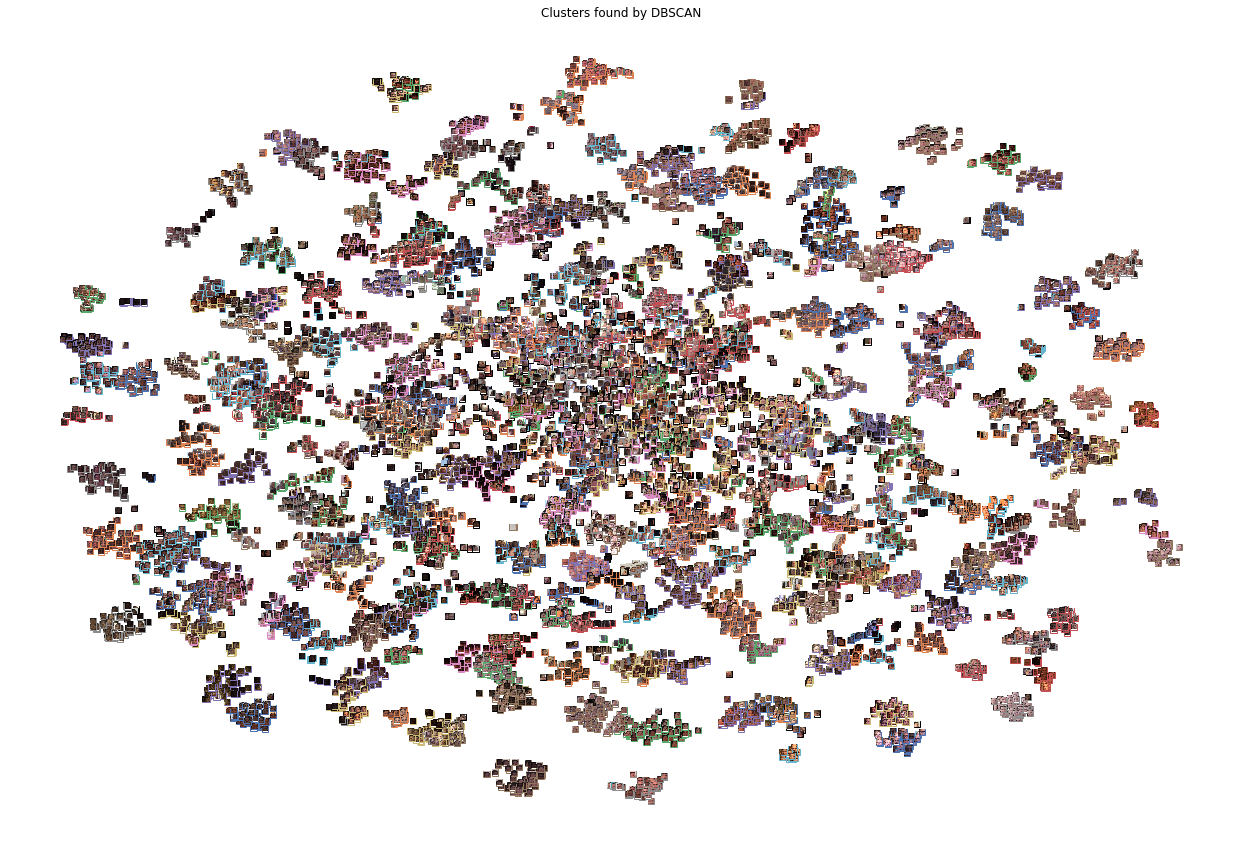

In [11]:
palette = sns.color_palette('deep', np.max(clusters) + 1)
colors = [palette[x] if x >= 0 else (0,0,0) for x in clusters]
ax = scatter_thumbnails(x, faces_all, 0.06, colors)
plt.title(f'Clusters found by DBSCAN')

In [12]:
# cv2.destroyAllWindows()
for labelID in labelIDs[1:]:
    # find all indexes into the `data` array that belong to the
    # current label ID, then randomly sample a maximum of 25 indexes
    # from the set
    if labelID % 50 == 0:
        print("[INFO] faces for face ID: {}".format(labelID))
    idxs = np.where(clusters == labelID)[0]
    idxs = np.random.choice(idxs, size=min(100, len(idxs)),
        replace=False)

    # initialize the list of faces to include in the montage
    faces = []

    # loop over the sampled indexes
    for i in idxs:
        # load the input image and extract the face ROI
        face = faces_all[i]
        faces.append(face)

    # create a montage using 96x96 "tiles" with 5 rows and 5 columns
    montage = build_montages(faces, (96, 96), (10, 10))[0]

    # show the output montage
    title = "Face ID #{}".format(labelID)
    title = "Unknown Faces" if labelID == -1 else title
    cv2.imwrite('montages_imp/actor_'+str(labelID)+'.png',montage)
#     cv2.imshow(title, montage)
#     cv2.waitKey(1)
    

[INFO] faces for face ID: 0
[INFO] faces for face ID: 50
[INFO] faces for face ID: 100
[INFO] faces for face ID: 150
[INFO] faces for face ID: 200
[INFO] faces for face ID: 250
[INFO] faces for face ID: 300
[INFO] faces for face ID: 350
[INFO] faces for face ID: 400
[INFO] faces for face ID: 450
[INFO] faces for face ID: 500
[INFO] faces for face ID: 550


In [13]:
f = open('results_imp.pkl', "wb")
f.write(pickle.dumps([x, clusters, labelIDs]))
f.close()
# results = pickle.loads(open('results_imp.pkl', "rb").read())
# x, clusters, labelIDs = results